In [85]:
import numpy as np
import psutil
import os

In [86]:
zero = np.array([1, 0], dtype=complex)
one = np.array([0, 1], dtype=complex)

H = (1 / np.sqrt(2)) * np.array([[1, 1],
                                  [1, -1]], dtype=complex)

I = np.array(
    [[1,0],
     [0,1]]
)

X = np.array([[0, 1],
              [1, 0]], dtype=complex)

Y = np.array([[0, -1j],
              [1j, 0]], dtype=complex)

Z = np.array([[1, 0],
              [0, -1]], dtype=complex)

def Rx(theta):
    cos = np.cos(theta / 2)
    isin = -1j * np.sin(theta / 2)
    return np.array([[cos, isin],
                     [isin, cos]], dtype=complex)

def Rz(theta):
    exp_plus = np.exp(-1j * theta / 2)
    exp_minus = np.exp(1j * theta / 2)
    return np.array([[exp_plus, 0],
                     [0, exp_minus]], dtype=complex)

def Rzz(theta):
    exp_00 = np.exp(-1j * theta / 2)
    exp_11 = np.exp(-1j * theta / 2)
    exp_01 = np.exp(1j * theta / 2)
    exp_10 = np.exp(1j * theta / 2)

    RZZ = np.array([[exp_00, 0,      0,      0],
                    [0,      exp_01, 0,      0],
                    [0,      0,      exp_10, 0],
                    [0,      0,      0,      exp_11]], dtype=complex)
    return RZZ

In [87]:
def initialize_state(n, state_vector=None):
    if state_vector is not None:
        if len(state_vector) != 2**n:
            raise ValueError("State vector length does not match number of qubits.")
        state = state_vector.reshape([2]*n)
    else:
        state = zero
        for _ in range(n - 1):
            state = np.tensordot(state, zero, axes=0)
    return state

def apply_single_qubit_gate(state, gate, target):
    n_qubits = state.ndim
    state = np.moveaxis(state, target, 0)
    state = np.tensordot(gate, state, axes=([1], [0]))
    state = np.moveaxis(state, 0, target)
    return state

def apply_two_qubit_gate(state, gate, qubit1, qubit2):
    n_qubits = state.ndim
    permute_order = [qubit1, qubit2] + [i for i in range(n_qubits) if i != qubit1 and i != qubit2]
    state = np.transpose(state, permute_order)
    original_shape = state.shape
    state = state.reshape(4, -1)
    state = np.tensordot(gate, state, axes=([1], [0]))
    state = state.reshape([2, 2] + list(original_shape[2:]))
    inverse_permute_order = np.argsort(permute_order)
    state = np.transpose(state, inverse_permute_order)
    return state

def apply_hamiltonian_from_list(state:np.ndarray, pauli_list:list[tuple]):
        # accept this form:
        # [('IIIZZ', 1.0), ('IIZIZ', 1.0), ('ZIIIZ', 1.0), ('IIZZI', 1.0), ('IZZII', 1.0), ('ZZIII', 1.0)]

        # sum hamiltonian terms over the new state
        new_state = np.zeros(shape=state.shape, dtype=object)

        def get_gate(gate_str:str):
            if gate_str == 'I':
                return I
            if gate_str == 'Z':
                return Z
            raise Exception("No gate with name '{gate_str}'")

        def apply_hamiltonian_terms(term):
            gates, weights = term
            gate_indices = []
            combined_gate = np.array([[1]], dtype=object)
            for index in range(len(gates)):
                gate_str = gates[index]
                if gate_str == 'I':
                    continue
                gate_indices.append(index)
                combined_gate = np.kron(combined_gate, get_gate(gate_str))
            # indices not used in the gate
            # other_indices =  [i for i in range(len(self.state.shape)) if i not in gate_indices]
            # indices to swap with gate_indices
            used_indices = [i for i in range(len(gate_indices))]
            permuted_state = np.moveaxis(state, gate_indices, used_indices)
            reshaped_state = permuted_state.reshape(2 ** len(gate_indices), -1)
            updated_state = combined_gate @ reshaped_state 
            updated_state = updated_state.reshape(*(2,) * len(gate_indices), *permuted_state.shape[len(gate_indices):])
            updated_state = np.moveaxis(updated_state, used_indices, gate_indices)
            return updated_state * weights

        for term in pauli_list:
            term_state = apply_hamiltonian_terms(term)
            new_state += term_state
        return new_state

def create_cnot_gate():
    CNOT = np.array([[1, 0, 0, 0],
                     [0, 1, 0, 0],
                     [0, 0, 0, 1],
                     [0, 0, 1, 0]], dtype=complex)
    return CNOT

In [88]:
def qaoa_circuit_general(graph_edges, gamma_list, beta_list):
    n = max(max(edge) for edge in graph_edges) + 1  # Number of qubits
    p = len(gamma_list)  # Number of QAOA layers

    state = initialize_state(n)

    # Apply Hadamard gates to all qubits
    for qubit in range(n):
        state = apply_single_qubit_gate(state, H, target=qubit)

    for layer in range(p):
        gamma = gamma_list[layer]
        beta = beta_list[layer]

        # Cost Hamiltonian evolution
        for edge in graph_edges:
            qubit1, qubit2 = edge
            RZZ_gate = Rzz(2 * gamma)
            state = apply_two_qubit_gate(state, RZZ_gate, qubit1, qubit2)

        # Mixer Hamiltonian evolution
        for qubit in range(n):
            Rx_gate = Rx(2 * beta)
            state = apply_single_qubit_gate(state, Rx_gate, target=qubit)

    return state

In [89]:
# Define the edges of the graph (e.g., a triangle)
graph_edges = [(0, 1), (1, 2), (2, 0)]

# QAOA parameters for each layer
gamma_list = [np.pi / 4, np.pi / 4]
beta_list = [np.pi / 8, np.pi / 8]

# Run the QAOA circuit
final_state = qaoa_circuit_general(graph_edges, gamma_list, beta_list)

# Reshape and display the final state
n = 3  # Number of qubits
state_vector = final_state.reshape(-1)
states = [f"|{bin(i)[2:].zfill(n)}⟩" for i in range(2**n)]

print("Final state amplitudes:")
for idx, amplitude in enumerate(state_vector):
    print(f'{states[idx]}: {amplitude} probability {np.abs(amplitude)**2}')

norm = np.sum(np.abs(state_vector)**2)
print(f'\nNormalization check (should be 1): {norm}')


Final state amplitudes:
|000⟩: (-0.1250000000000002+0.1249999999999998j) probability 0.03125000000000001
|001⟩: (0.3749999999999998+0.12499999999999999j) probability 0.15624999999999983
|010⟩: (0.3749999999999998+0.12499999999999997j) probability 0.15624999999999983
|011⟩: (0.3749999999999998+0.12499999999999993j) probability 0.15624999999999983
|100⟩: (0.3749999999999999+0.12499999999999996j) probability 0.15624999999999994
|101⟩: (0.3749999999999997+0.125j) probability 0.1562499999999998
|110⟩: (0.3749999999999998+0.125j) probability 0.15624999999999983
|111⟩: (-0.12500000000000014+0.1249999999999998j) probability 0.031249999999999986

Normalization check (should be 1): 0.9999999999999991


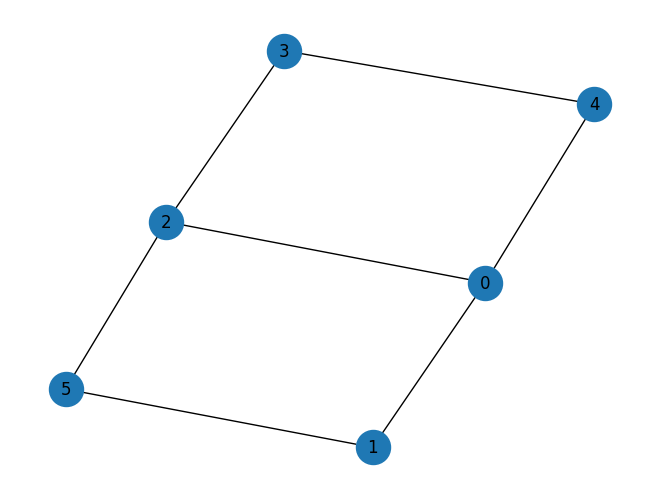

In [90]:
import rustworkx as rx
from rustworkx.visualization import mpl_draw as draw_graph
import numpy as np

n = 6

graph = rx.PyGraph()
graph.add_nodes_from(np.arange(0, n, 1))
# edge_list = [(0, 1, 1.0), (1, 2, 1.0), (2, 3, 1.0), (3, 0, 1.0)] #n = 4
# edge_list = [(0, 1, 1.0), (0, 2, 1.0), (0, 4, 1.0), (1, 2, 1.0), (2, 3, 1.0), (3, 4, 1.0)] #n=5
edge_list = [(0, 1, 1.0), (0, 2, 1.0), (0, 4, 1.0), (1, 5, 1.0), (2, 3, 1.0), (3, 4, 1.0), (2, 5, 1.0)]
graph.add_edges_from(edge_list)
draw_graph(graph, node_size=600, with_labels=True)

In [91]:
# QAOA parameters for each layer
gamma_list = [np.pi / 4, np.pi / 4]
beta_list = [np.pi / 8, np.pi / 8]

qc_edge_list = [(edge[0], edge[1]) for edge in edge_list]

# Run the QAOA circuit
final_state = qaoa_circuit_general(qc_edge_list, gamma_list, beta_list)

state_vector = final_state.reshape(-1)
states = [f"|{bin(i)[2:].zfill(n)}⟩" for i in range(2**n)]

print("Final state amplitudes:")
for idx, amplitude in enumerate(state_vector):
    print(f'{states[idx]}: {amplitude} probability {np.abs(amplitude)**2}')

norm = np.sum(np.abs(state_vector)**2)
print(f'\nNormalization check (should be 1): {norm}')

Final state amplitudes:
|000000⟩: (-0.09374999999999992-4.495220130101138e-17j) probability 0.008789062499999984
|000001⟩: (0.0624999999999999+0.09374999999999996j) probability 0.01269531249999998
|000010⟩: (0.06249999999999991+0.09374999999999996j) probability 0.01269531249999998
|000011⟩: (0.031249999999999993+0.12499999999999996j) probability 0.016601562499999986
|000100⟩: (0.062499999999999944+0.09374999999999994j) probability 0.01269531249999998
|000101⟩: (0.031249999999999962+4.8840845481563854e-17j) probability 0.0009765624999999976
|000110⟩: (0.15624999999999983+0.12499999999999996j) probability 0.040039062499999944
|000111⟩: (0.06249999999999996-0.03124999999999997j) probability 0.004882812499999993
|001000⟩: (-0.12499999999999992-0.09374999999999993j) probability 0.024414062499999965
|001001⟩: (-0.09374999999999992-1.2229796842713743e-17j) probability 0.008789062499999984
|001010⟩: (0.031249999999999965-0.12499999999999989j) probability 0.016601562499999972
|001011⟩: (-2.5178

# create hamiltonian

In [92]:
from qiskit.quantum_info import SparsePauliOp
def build_max_cut_paulis(graph: rx.PyGraph) -> list[tuple[str, float]]:
    """Convert the graph to Pauli list.

    This function does the inverse of `build_max_cut_graph`
    """
    pauli_list = []
    for edge in list(graph.edge_list()):
        paulis = ["I"] * len(graph)
        paulis[edge[0]], paulis[edge[1]] = "Z", "Z"

        weight = graph.get_edge_data(edge[0], edge[1])

        pauli_list.append(("".join(paulis)[::-1], weight))

    return pauli_list

max_cut_paulis = build_max_cut_paulis(graph)

In [93]:
import optuna
from scipy.optimize import minimize


qc_edge_list = [(edge[0], edge[1]) for edge in edge_list]

iter_energy = []

def objective(params):
    gamma_0, gamma_1, beta_0, beta_1 = params
    gamma_list = [gamma_0, gamma_1]
    beta_list = [beta_0, beta_1]
    final_state = qaoa_circuit_general(qc_edge_list, gamma_list, beta_list)
    phi_state = apply_hamiltonian_from_list(final_state, max_cut_paulis)
    energy = np.vdot(final_state.reshape(-1), phi_state.reshape(-1)).real
    iter_energy.append(energy)
    return energy
    
result = minimize(
    objective,              # Objective function
    [np.pi / 4, np.pi / 4, np.pi / 8, np.pi / 8],          # Initial guess for the parameters
    method='COBYLA',      # Optimization method
    bounds=[(0, 2 * np.pi), (0, 2 * np.pi), (0, 2 * np.pi), (0, 2 * np.pi)],  # Optional bounds on x and y
    tol=1e-4
)

print("Optimal parameters:", result.x)
print("Minimum value of objective function:", result.fun)

gamma_0, gamma_1, beta_0, beta_1 = result.x

gamma_list = [gamma_0, gamma_1]
beta_list = [beta_0, beta_1]

final_state = qaoa_circuit_general(qc_edge_list, gamma_list, beta_list).reshape(-1)
final_state_probabilities = np.abs(final_state) ** 2

final_distribution_int = {state_int: final_state_probabilities[state_int] for state_int in range(len(final_state_probabilities))}
final_distribution_bin = {format(state_int, '0%db' % n): final_state_probabilities[state_int] for state_int in range(len(final_state_probabilities))}

Optimal parameters: [1.92337283 0.8233849  1.30965731 0.22048695]
Minimum value of objective function: -1.1043744994877915


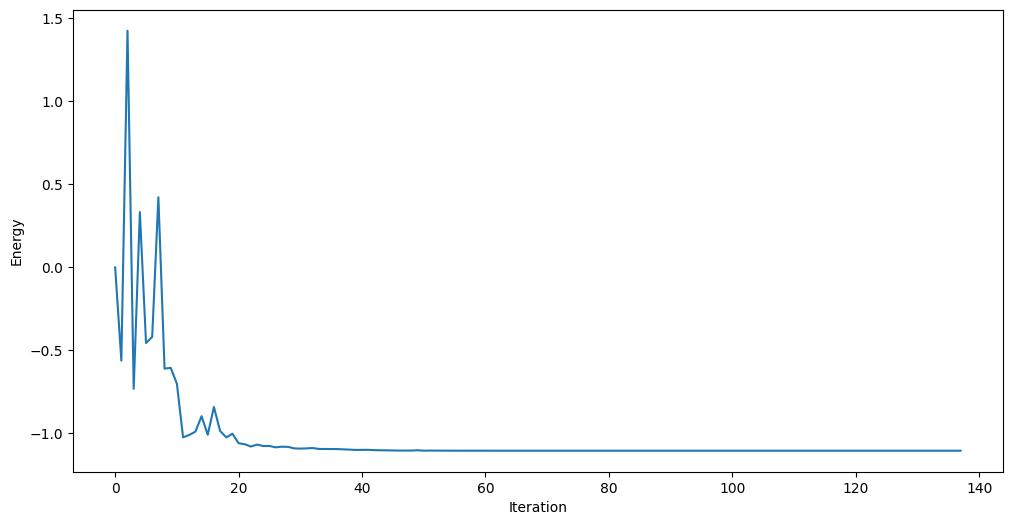

In [94]:
import matplotlib.pyplot as plt

plt.figure(figsize=(12, 6))
plt.plot(iter_energy)
plt.xlabel("Iteration")
plt.ylabel("Energy")
plt.show()

Result bitstring: [0, 1, 1, 0, 1, 0]


<BarContainer object of 64 artists>

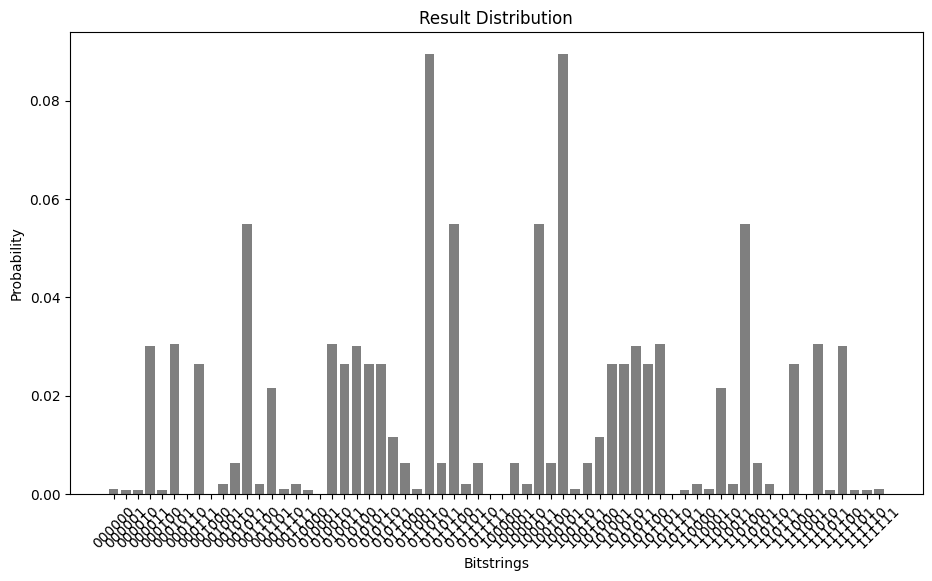

In [95]:
import matplotlib

def to_bitstring(integer, num_bits):
    result = np.binary_repr(integer, width=num_bits)
    return [int(digit) for digit in result]

keys = list(final_distribution_int.keys())
values = list(final_distribution_int.values())
most_likely = keys[np.argmax(np.abs(values))]
most_likely_bitstring = to_bitstring(most_likely, len(graph))

print("Result bitstring:", most_likely_bitstring)

matplotlib.rcParams.update({"font.size": 10})
final_bits = final_distribution_bin
values = np.abs(list(final_bits.values()))
positions = []
fig = plt.figure(figsize=(11, 6))
ax = fig.add_subplot(1, 1, 1)
plt.xticks(rotation=45)
plt.title("Result Distribution")
plt.xlabel("Bitstrings")
plt.ylabel("Probability")
ax.bar(list(final_bits.keys()), list(final_bits.values()), color="tab:grey")

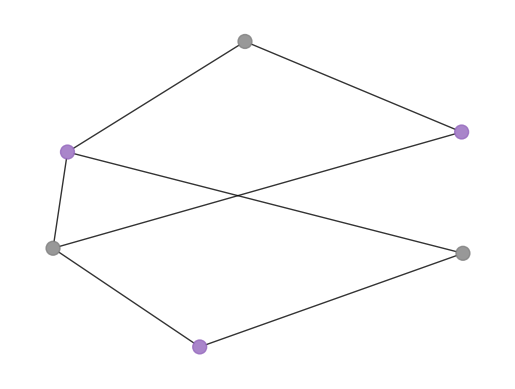

In [96]:
# auxiliary function to plot graphs
def plot_result(G, x):
    colors = ["tab:grey" if i == 0 else "tab:purple" for i in x]
    pos, default_axes = rx.spring_layout(G), plt.axes(frameon=True)
    rx.visualization.mpl_draw(G, node_color=colors, node_size=100, alpha=0.8, pos=pos)


plot_result(graph, most_likely_bitstring)